/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


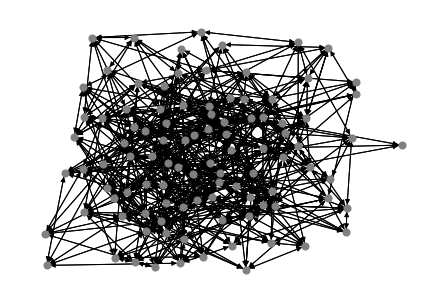

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

N = 100
DAMP = 0.85
K = 10
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5]])
plt.show()

In [7]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [8]:
def pagerank_message_func(edges):
    return {'pv': edges.src['pv'] / edges.src['deg']}

In [9]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv': pv}

In [10]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

In [11]:
def pagerank_naive(g):
    for u, v in zip(*g.edges()):
        g.send((u, v))
    for v in g.nodes():
        g.recv(v)

In [12]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

In [13]:
def pagerank_level2(g):
    g.update_all()

In [17]:
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [18]:
for k in range(K):
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0080, 0.0074, 0.0054, 0.0095, 0.0068, 0.0081, 0.0081, 0.0069, 0.0079,
        0.0082, 0.0106, 0.0063, 0.0067, 0.0086, 0.0086, 0.0101, 0.0088, 0.0093,
        0.0081, 0.0099, 0.0075, 0.0074, 0.0068, 0.0073, 0.0054, 0.0087, 0.0081,
        0.0082, 0.0101, 0.0101, 0.0095, 0.0074, 0.0107, 0.0080, 0.0074, 0.0074,
        0.0093, 0.0063, 0.0083, 0.0086, 0.0115, 0.0107, 0.0114, 0.0080, 0.0055,
        0.0086, 0.0069, 0.0049, 0.0083, 0.0087, 0.0079, 0.0109, 0.0120, 0.0093,
        0.0074, 0.0115, 0.0056, 0.0074, 0.0068, 0.0110, 0.0054, 0.0086, 0.0093,
        0.0113, 0.0049, 0.0082, 0.0055, 0.0111, 0.0094, 0.0063, 0.0102, 0.0080,
        0.0061, 0.0068, 0.0081, 0.0095, 0.0093, 0.0067, 0.0092, 0.0064, 0.0075,
        0.0124, 0.0089, 0.0087, 0.0122, 0.0061, 0.0109, 0.0093, 0.0101, 0.0034,
        0.0054, 0.0067, 0.0094, 0.0048, 0.0063, 0.0067, 0.0094, 0.0071, 0.0081,
        0.0100])


/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
